In [ ]:
import numpy as np
import cv2
import trackpy as tp
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
def contour_on_border(c,width,height):
    xmin = 1
    ymin = 1
    xmax = width
    ymax = height
    
    x,y,w,h = cv2.boundingRect(c)
    return (x <= xmin or y <= ymin or w >= xmax or h >= ymax)

def get_copepod_location(frame,thresh_level):
    width = np.shape(frame)[1]
    height = np.shape(frame)[0]

    imgray = cv2.equalizeHist(frame) 
    blur = cv2.GaussianBlur(imgray,(9,9),0)
    ret, thresh = cv2.threshold(blur, thresh_level, 255, 0)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    areas = [cv2.contourArea(c) * (not contour_on_border(c,width,height)) for c in contours]
    
    # copepod is assumed to be the largest contour that IS NOT touching the border. this could fail if there are two copepods
    copepod_contour = np.argmax(areas)
    M = cv2.moments(contours[copepod_contour])
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    return (cX,cY,imgray,thresh)

In [47]:
#cap = cv2.VideoCapture('Feedswim_with_tailtwitch_May23_Acartia09.avi')
# need to be able to locate video in remote location, not in the working directory
cap = cv2.VideoCapture('Parvocalanus_crassirostris_2_20180518_132104.avi')

cXsum = 0
cYsum = 0

thresh_level = 50;

width = int(cap.get(3))
height = int(cap.get(4))

s2 = 150 # size of crop box in pixels divided by 2
framesum = np.zeros((2*s2,2*s2))

N = 1000 # number of frames to read, starting at 1
n_frames = 1

# TODO: would taking the average frame twice help get rid of fixed pattern noise? 
# first time with full, stationary frame, second time with frame following copepod
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret is True and n_frames <= N:
        orig = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        (cX,cY,frame,thresh) = get_copepod_location(orig,thresh_level)
        frame = frame[cY - s2 : cY + s2, cX - s2 : cX + s2]
        
        # create dataframe that logs copepod position AND frame position as a function of frame #
        # this is used to calculate drift correction later
        cXsum += cX
        cYsum += cY
        framesum += frame
        if n_frames%100 == 0:
            print(n_frames)  
        n_frames += 1
    else:
        print("finished!")
        break

cap.release()
cv2.destroyAllWindows()

100
200
300
400
500
600
700
800
900
1000
finished!


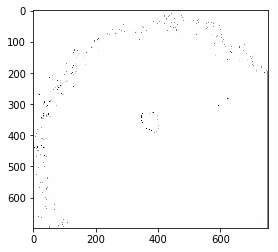

In [48]:
plt.imshow(thresh, cmap = 'Greys')
plt.show()

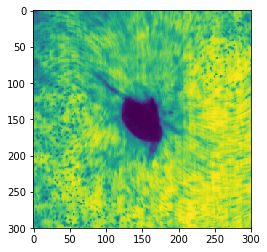

In [49]:
cXav = cXsum / n_frames
cYav = cYsum / n_frames
background = framesum / n_frames

plt.imshow(background)
plt.show()

In [56]:
cap = cv2.VideoCapture('Parvocalanus_crassirostris_2_20180518_132104.avi')

particle_size = 5 # ~average particle size in pixels
n = 1

animate = True

while(cap.isOpened()):
    ret, frame = cap.read()
    if ret is True and n <= N:
        orig = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        (cX,cY,frame,thresh) = get_copepod_location(orig, thresh_level)
        orig = orig[cY - s2 : cY + s2, cX - s2 : cX + s2]
        frame = frame[cY - s2 : cY + s2, cX - s2 : cX + s2]
        frame_subtracted = frame-background
        
        # renormalize the background subtracted frame
        frame_subtracted = frame_subtracted - frame_subtracted.min()
        frame_subtracted *= (255.0/frame_subtracted.max())
        frame_subtracted = frame_subtracted.astype('uint8')

        # track particles! maybe try on the original frame
        f = tp.locate(frame_subtracted, particle_size, invert=True)
        f['frame'] = n # add video frame number to dataframe
        if n > 1:
            ff = pd.concat([ff,f])
        else:
            ff = f
        if n%100 == 0:
            print(n)
        n += 1

        if animate:
            frame_subtracted = cv2.cvtColor(frame_subtracted, cv2.COLOR_GRAY2BGR)
            orig = cv2.cvtColor(orig, cv2.COLOR_GRAY2BGR)

            for index,row in f.iterrows():
                cv2.circle(frame_subtracted,(int(row['x']),int(row['y'])),0,(0,0,255))

            anim = np.concatenate((orig,frame_subtracted), axis=1)
            anim = cv2.resize(anim,None,fx=2, fy=2, interpolation = cv2.INTER_CUBIC)

            cv2.imshow('frame',anim)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
    else:
        print("finished!")
        break

cap.release()
cv2.destroyAllWindows()

100
200
300
400
500
600
700
800
900
1000
finished!


In [51]:
# link particles to create trajectories between frames

dpf = 1; # max particle displacement between frames in pixels
t = tp.link_df(ff, dpf, memory=10) # memory: how many "dropped" frames to allow

Frame 1000: 877 trajectories present.


In [52]:
min_duration = 50 # [number of frames]

t1 = tp.filter_stubs(t, min_duration) # filter out trajectories of durations less than minimum 
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())

('Before:', 74302)
('After:', 3482)


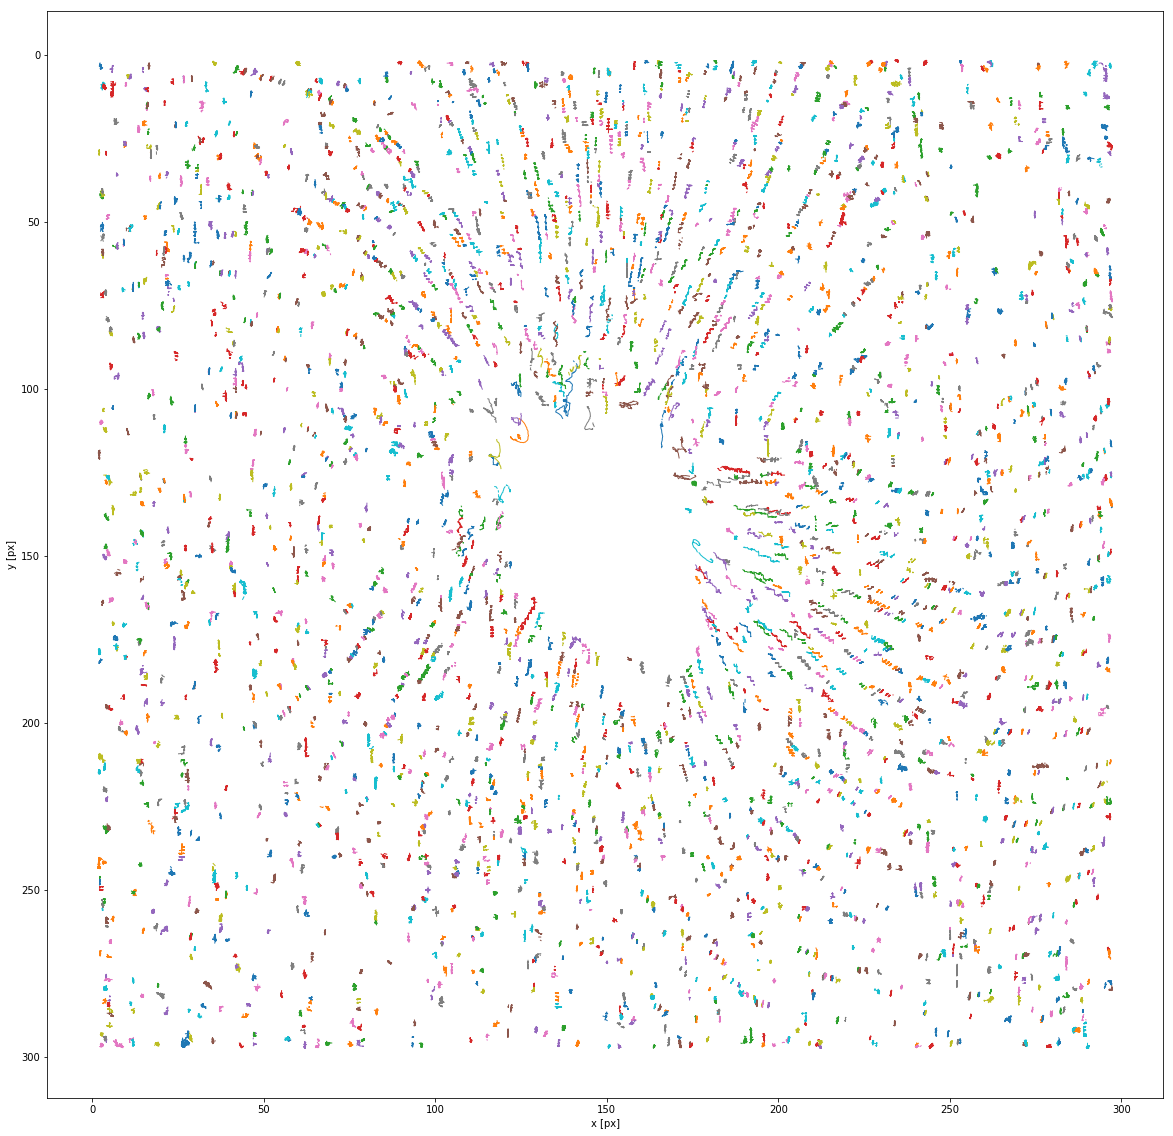

In [53]:
plt.figure(figsize=(20,20))
tp.plot_traj(t1)

<Figure size 432x288 with 0 Axes>

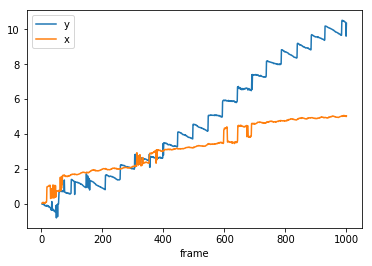

In [54]:
d = tp.compute_drift(t1)
plt.figure()
d.plot()

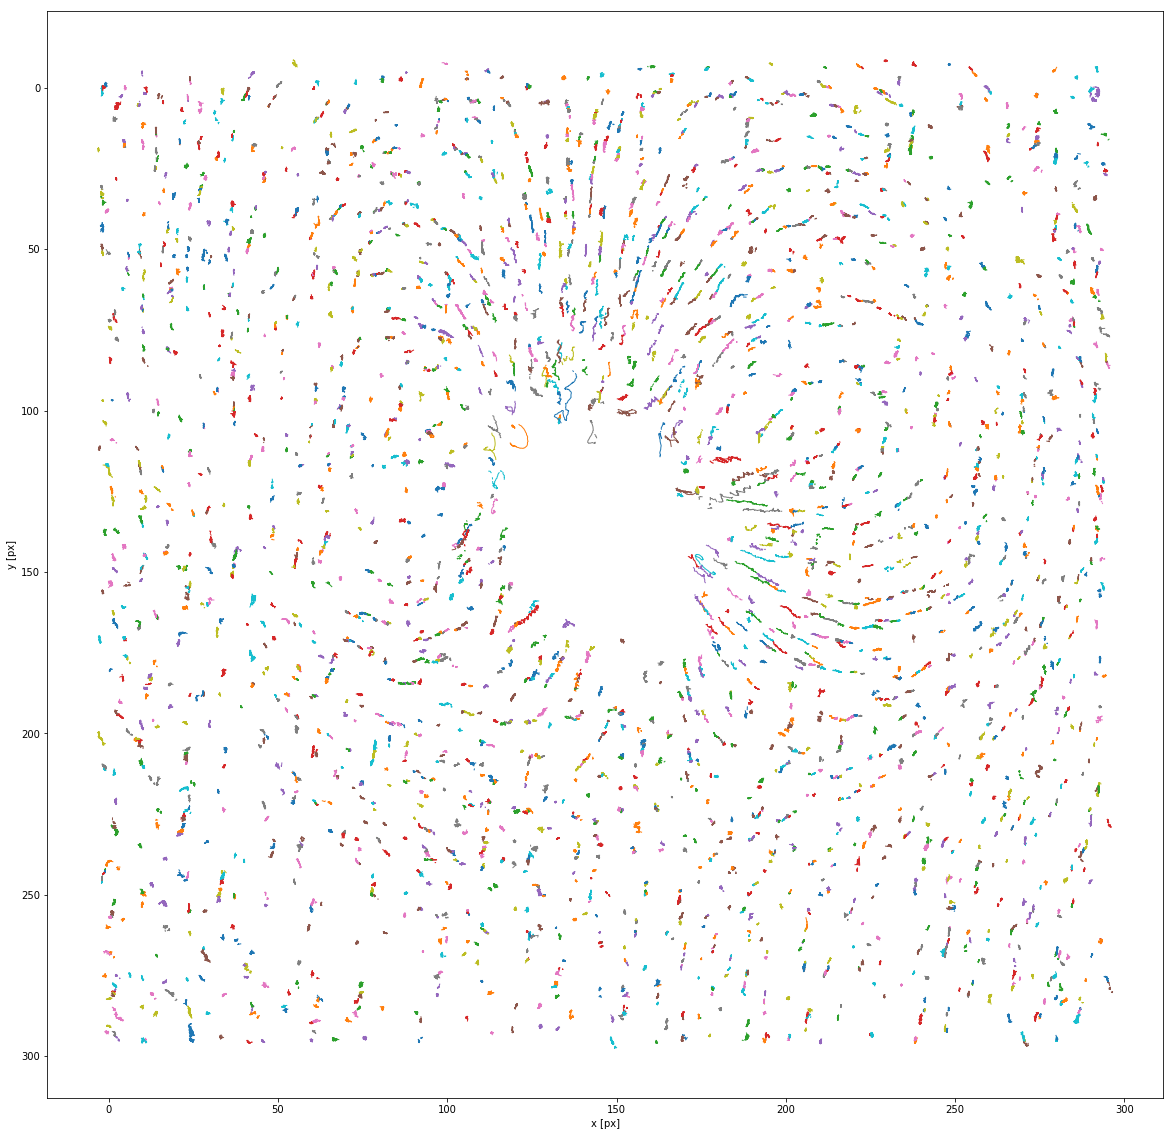

In [55]:
tm = tp.subtract_drift(t1.copy(), d)
plt.figure(figsize=(20,20))
ax = tp.plot_traj(tm)

# add code to save figure

In [58]:
t1.to_csv('test.csv') # easy to save dataframes to csv

# maybe add code for saving all relevant data into one hdf5 file

In [59]:
print(t1)

                y           x        mass      size       ecc     signal  \
frame                                                                      
1      201.782178   47.103960   59.991900  1.085457  0.171515  17.225397   
1      189.404938  226.633333  120.280790  1.094881  0.283611  29.698960   
1      189.316800  272.846400   92.809252  1.245793  0.353710  16.779913   
1      190.281690  190.205231   73.801917  1.228436  0.257218  12.473563   
1      194.188192  280.051661   80.484183  1.079839  0.339344  17.076902   
1      213.041494  274.302905   35.787247  1.117570  0.571282   9.206678   
1      206.888309  125.203549  142.258021  1.252971  0.101677  21.383252   
1      209.095541  233.925690   69.941052  1.139896  0.242605  14.107006   
1      213.257053  147.018809   94.739684  1.231764  0.013070  14.403996   
1      158.058544   43.118671   93.848715  1.229902  0.120331  15.294965   
1      150.246554   30.196018   96.967106  1.149605  0.541329  18.116366   
1      156.1